In [13]:
import rioxarray as rio
import xarray as xr
import numpy as np

from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay
from scipy import ndimage

import matplotlib.pyplot as plt
import glob

## Get dem

In [15]:
dem = rio.open_rasterio('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ancil/eu_dem_v11_1km.tif')

dem = xr.where(dem<-1e20,0,dem)
dem = dem.sel(x=slice(-12,4),y=slice(63,49))

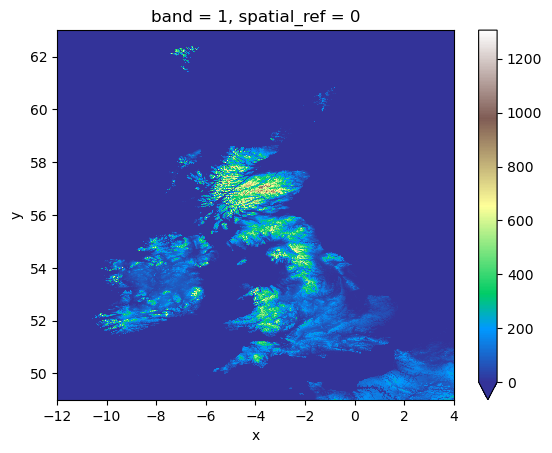

In [16]:
dem.plot(vmin=0,cmap='terrain')

# plot era5 footprint

In [17]:
era5_footprint = rio.open_rasterio('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/WISC/data/event_set_tif/2022_mem0.tif')

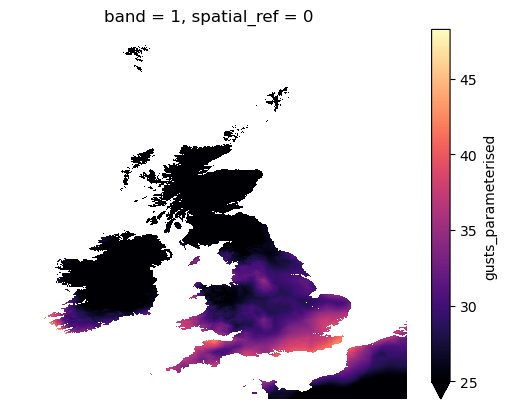

In [19]:
g=era5_footprint.where(dem!=0).plot(cmap='magma',vmin=25)

g.axes.axis('off');

## test out WISC parameterisation on ensemble member

In [50]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator, CloughTocher2DInterpolator
from scipy.spatial import Delaunay

import matplotlib.pyplot as plt

In [51]:
mem = xr.open_dataset('/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-16.nc',chunks={'time':1})

mem = mem.sel(time=slice('2022-02-17','2022-02-19 23'),longitude=slice(-12,4),latitude=slice(63,49))

In [52]:
## set up interp func:
lons = mem.longitude.values
lats = mem.latitude.values

points = np.array(np.meshgrid(lons,lats)).reshape(2,-1).swapaxes(0,1)

tri = Delaunay(points)

def interp_vals(A, x, y):
    # print(A.shape)
    
    points_out = np.array(np.meshgrid(x,y)).reshape(2,-1).swapaxes(0,1)
    
    interp = LinearNDInterpolator(tri,A.flatten())
    
    return interp(points_out).reshape(y.size,x.size)

In [53]:
mem_remap = xr.apply_ufunc(
    interp_vals,
    mem,
    dem.x.values,
    dem.y.values,
    input_core_dims=[['latitude','longitude'],['lon'],['lat']],
    output_core_dims=[['lat','lon']],
    exclude_dims=set(('latitude','longitude'),),
    vectorize=True,
    dask='parallelized',
    output_dtypes = np.float32
)

mem_remap['lon'] = dem.x.values
mem_remap['lat'] = dem.y.values
mem_remap['dem'] = (('lat','lon'), dem.squeeze().values)

In [54]:
def gust_parameterisation(ds):
    
    u10 = np.sqrt(ds.u10**2+ds.v10**2)
    u100 = np.sqrt(ds.u100**2+ds.v100**2)
    
    wgSLH = u10 + 3.25 * (u100 - u10) / np.log(100/10)
    
    wg_out = 10.3 + 0.0112*ds.fg10**2 + 0.0148 * wgSLH**2 + 0.00355 * ds.dem
    
    return wg_out.rename('gusts_parameterised')

In [55]:
footprint = gust_parameterisation(mem_remap).max('time')

In [56]:
footprint = footprint.compute()

In [57]:
footprint.rename(lat='y',lon='x').rio.to_raster('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/WISC/data/event_set_tif/test.tif')

/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/l/leach/installed-packages/miniconda3/lib/python3.7/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
